## Importing Modules

In [ ]:
%%capture
!pip install 'transformers == 4.6.0'

In [ ]:
import zipfile
import pandas as pd 
import numpy as np
import re
import random 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from tensorflow.keras import layers 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
from sklearn.metrics import confusion_matrix
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

## Loading Data

In [ ]:
zip_path= "/content/drive/MyDrive/Hate Speech Detection Data/train_E6oV3lV.csv.zip"

In [ ]:
# Create function to unzip a zipfile into current working directory 
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()
unzip_data(zip_path)

In [ ]:
# Read csv file
df = pd.read_csv("/content/train_E6oV3lV.csv")

In [ ]:
# Check data
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
# Drop the id column
df = df.drop('id',axis=1)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
# Shuffle the data 
df_shuffled = df.sample(frac=1, random_state=42)
df_shuffled.head()

,label,tweet
12227,0,@user âmy mom says my smile is captivatingâ...
14709,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,0,hating the conservative homophobes using this ...
4308,0,awee if this doesn't #scream #friday #acewe...
24055,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


## Processing Data

In [ ]:
# Remove symbols from tweets and lower case all characters
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [ ]:
df_shuffled['processed_tweets'] = df_shuffled['tweet'].apply(process_tweet)
df_shuffled.head(8)

,label,tweet,processed_tweets
12227,0,@user âmy mom says my smile is captivatingâ...,my mom says my smile is captivating i says hap...
14709,0,"in 3 days i will be meeting my sis-n-law, coun...",in 3 days i will be meeting my sis n law coune...
19319,0,hating the conservative homophobes using this ...,hating the conservative homophobes using this ...
4308,0,awee if this doesn't #scream #friday #acewe...,awee if this doesn t scream friday acewellstuc...
24055,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...,fathersday father s day god tony a smith buy t...
2275,0,grooving fuuuunn nightâ¨â¨â¨ #bangkok #las...,grooving fuuuunn night bangkok lastnight w tha...
22304,0,a very #koala bear,a very koala bear
15297,0,treat people the way you want to be treated. #...,treat people the way you want to be treated be...


## Splitting Data into Training and Validation Sets

In [ ]:
# Use train_test_split to split training data into training and validation sets 
train_sentences, val_sentences, train_labels, val_labels = train_test_split(list(df_shuffled["processed_tweets"]),
                                                                           list(df_shuffled["label"]),
                                                                           test_size=0.2, # use 20% of training data for validation
                                                                           random_state=42)

In [ ]:
# Find the average number of tokens (words) in the training and validation tweets 
round (sum([len(i.split()) for i in train_sentences])/len(train_sentences)), round (sum([len(i.split()) for i in val_sentences])/len(val_sentences))

(13, 13)

## Running a Series of Modeling Experiments

In [ ]:
# Create tokenization and modeling pipeline 


# XGBClassifier
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', xgb.XGBClassifier(use_label =False)),])

model_0 = pipeline_xgb.fit(train_sentences, train_labels)

model_0_score = model_0.score(val_sentences, val_labels)

print(f"Our model_0 (XGBClassifier) achieves an accuracy of:{model_0_score*100:.2f}%")


# MultinomialNB
model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", MultinomialNB()) # model the text
])

model_1.fit(train_sentences, train_labels)
score_1 = model_1.score(val_sentences, val_labels)
print(f"Our model_1 (MultinomialNB) achieves an accuracy of:{score_1*100:.2f}%")


# RandomForestClassifier
model_2 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", RandomForestClassifier()) # model the text
])

model_2.fit(train_sentences, train_labels)
score_2 = model_2.score(val_sentences, val_labels)
print(f"Our model_2 (RandomForestClassifier) achieves an accuracy of:{score_2*100:.2f}%")


# LogisticRegression
model_3 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", LogisticRegression()) # model the text
])

model_3.fit(train_sentences, train_labels)
score_3 = model_3.score(val_sentences, val_labels)
print(f"Our model_3 (LogisticRegression) achieves an accuracy of:{score_3*100:.2f}%")


# SGDClassifier
model_4 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf 
                    ("clf", SGDClassifier()) # model the text
])

model_4.fit(train_sentences, train_labels)
score_4 = model_4.score(val_sentences, val_labels)
print(f"Our model_4 (SGDClassifier) achieves an accuracy of:{score_4*100:.2f}%")

Our model_0 (XGBClassifier) achieves an accuracy of:94.17%
Our model_1 (MultinomialNB) achieves an accuracy of:93.52%
Our model_2 (RandomForestClassifier) achieves an accuracy of:96.15%
Our model_3 (LogisticRegression) achieves an accuracy of:94.81%
Our model_4 (SGDClassifier) achieves an accuracy of:95.07%


In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub 
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE"
                                        )
# Create model using the Sequential API 
model_5 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name = "model_5_USE")

# Compile 
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings 
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=15,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/15
800/800 [==============================] - 23s 23ms/step - loss: 0.1742 - accuracy: 0.9433 - val_loss: 0.1369 - val_accuracy: 0.9478
Epoch 2/15
800/800 [==============================] - 18s 22ms/step - loss: 0.1223 - accuracy: 0.9561 - val_loss: 0.1316 - val_accuracy: 0.9518
Epoch 3/15
800/800 [==============================] - 18s 22ms/step - loss: 0.1124 - accuracy: 0.9591 - val_loss: 0.1242 - val_accuracy: 0.9529
Epoch 4/15
800/800 [==============================] - 18s 22ms/step - loss: 0.1025 - accuracy: 0.9621 - val_loss: 0.1222 - val_accuracy: 0.9534
Epoch 5/15
800/800 [==============================] - 17s 22ms/step - loss: 0.0938 - accuracy: 0.9660 - val_loss: 0.1171 - val_accuracy: 0.9571
Epoch 6/15
800/800 [==============================] - 17s 22ms/step - loss: 0.0856 - accuracy: 0.9688 - val_loss: 0.1131 - val_accuracy: 0.9582
Epoch 7/15
800/800 [==============================] - 17s 22ms/step - loss: 0.0783 - accuracy: 0.9715 - val_loss: 0.1126 - val_accuracy:

In [ ]:
# Make predictions with USE TF Hub Model
model_5_pred_probs = model_5.predict(val_sentences)

In [ ]:
# Making predictions on validation data 
y0_predict = model_0.predict(val_sentences)
y1_predict = model_1.predict(val_sentences)
y2_predict = model_2.predict(val_sentences)
y3_predict = model_3.predict(val_sentences)
y4_predict = model_4.predict(val_sentences)
y5_predict = tf.squeeze(tf.round(model_5_pred_probs))

## Creating an Evaluation Function for Model Experiments

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model 
  """
  # Calculate model accuracy 
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average 
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results 
model_0_results = calculate_results(y_true=val_labels,
                                     y_pred= y0_predict)
model_0_results

{'accuracy': 94.16549350852495,
 'f1': 0.9240085458148133,
 'precision': 0.9416924045330635,
 'recall': 0.9416549350852494}

In [ ]:
# Get model_1 results 
model_1_results = calculate_results(y_true=val_labels,
                                     y_pred= y1_predict)
model_1_results

{'accuracy': 93.52416705771938,
 'f1': 0.9103555383590493,
 'precision': 0.9394690355064025,
 'recall': 0.9352416705771938}

In [ ]:
# Get model_2 results 
model_2_results = calculate_results(y_true=val_labels,
                                     y_pred= y2_predict)
model_2_results

{'accuracy': 96.15204129516658,
 'f1': 0.9561775703067548,
 'precision': 0.9605289818711626,
 'recall': 0.9615204129516659}

In [ ]:
# Get model_3 results 
model_3_results = calculate_results(y_true=val_labels,
                                     y_pred= y3_predict)
model_3_results

{'accuracy': 94.80681995933051,
 'f1': 0.9359882323688977,
 'precision': 0.9466040133565261,
 'recall': 0.9480681995933051}

In [ ]:
# Get model_4 results 
model_4_results = calculate_results(y_true=val_labels,
                                     y_pred= y4_predict)
model_4_results

{'accuracy': 95.07273580478649,
 'f1': 0.9396594391222164,
 'precision': 0.9507792098849407,
 'recall': 0.9507273580478649}

In [ ]:
# Get model_5 results 
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = y5_predict)
model_5_results

{'accuracy': 96.12075707805413,
 'f1': 0.9583718317085882,
 'precision': 0.9582698898604834,
 'recall': 0.9612075707805412}

## Comparing the Performance of the Models

In [ ]:
models_results_df = pd.DataFrame(data={'model_0 (XGBClassifier)': model_0_results,
                                       'model_1 (MultinomialNB)': model_1_results,
                                       'model_2 (RandomForestClassifier)' : model_2_results,
                                       'model_3 (LogisticRegression)': model_3_results,
                                       'model_4 (SGDClassifier)' : model_4_results,
                                       'model_5 (TFhub_USE_Encoder)' : model_5_results}).transpose()
models_results_df

,accuracy,precision,recall,f1
model_0 (XGBClassifier),94.165494,0.941692,0.941655,0.924009
model_1 (MultinomialNB),93.524167,0.939469,0.935242,0.910356
model_2 (RandomForestClassifier),96.152041,0.960529,0.961520,0.956178
model_3 (LogisticRegression),94.806820,0.946604,0.948068,0.935988
model_4 (SGDClassifier),95.072736,0.950779,0.950727,0.939659
model_5 (TFhub_USE_Encoder),96.120757,0.958270,0.961208,0.958372


In [ ]:
# Reduce the accuracy to the same scale as other metrics 
models_results_df["accuracy"]= models_results_df["accuracy"]/100

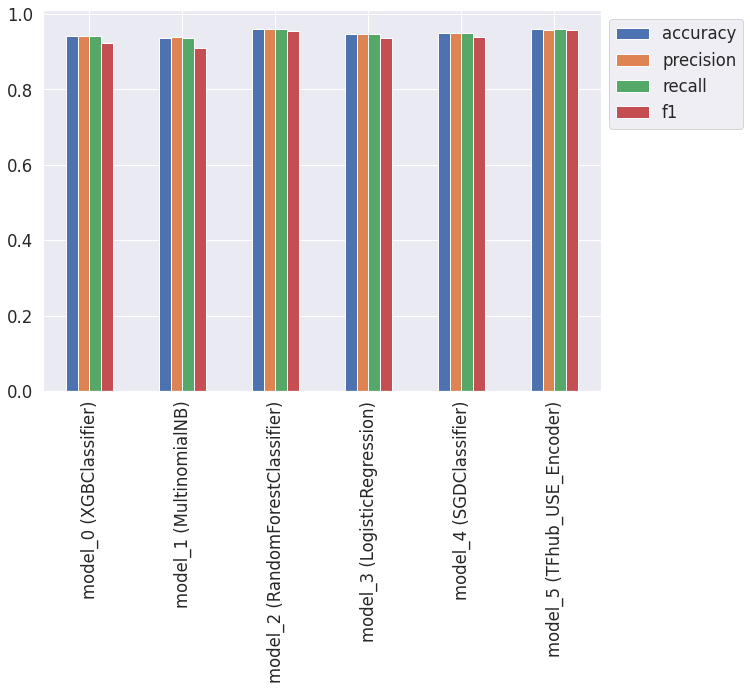

In [ ]:
# Plot and compare all of the model results
models_results_df.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

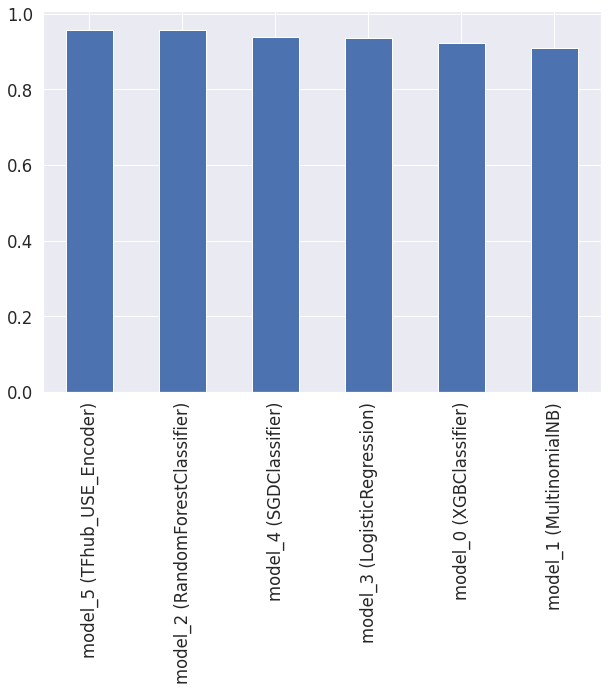

In [ ]:
# Sort model results by f1-score
models_results_df.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# Confusion matrix
cm_0 = confusion_matrix(val_labels, y0_predict)
cm_0

array([[5922,    6],
       [ 367,   98]])

In [ ]:
cm_1 = confusion_matrix(val_labels, y1_predict)
cm_1

array([[5928,    0],
       [ 414,   51]])

In [ ]:
cm_2 = confusion_matrix(val_labels, y2_predict)
cm_2

array([[5911,   17],
       [ 229,  236]])

In [ ]:
cm_3 = confusion_matrix(val_labels, y3_predict)
cm_3

array([[5915,   13],
       [ 319,  146]])

In [ ]:
cm_4 = confusion_matrix(val_labels, y4_predict)
cm_4

array([[5920,    8],
       [ 307,  158]])

In [ ]:
cm_5 = confusion_matrix(val_labels, y5_predict)
cm_5

array([[5867,   61],
       [ 187,  278]])

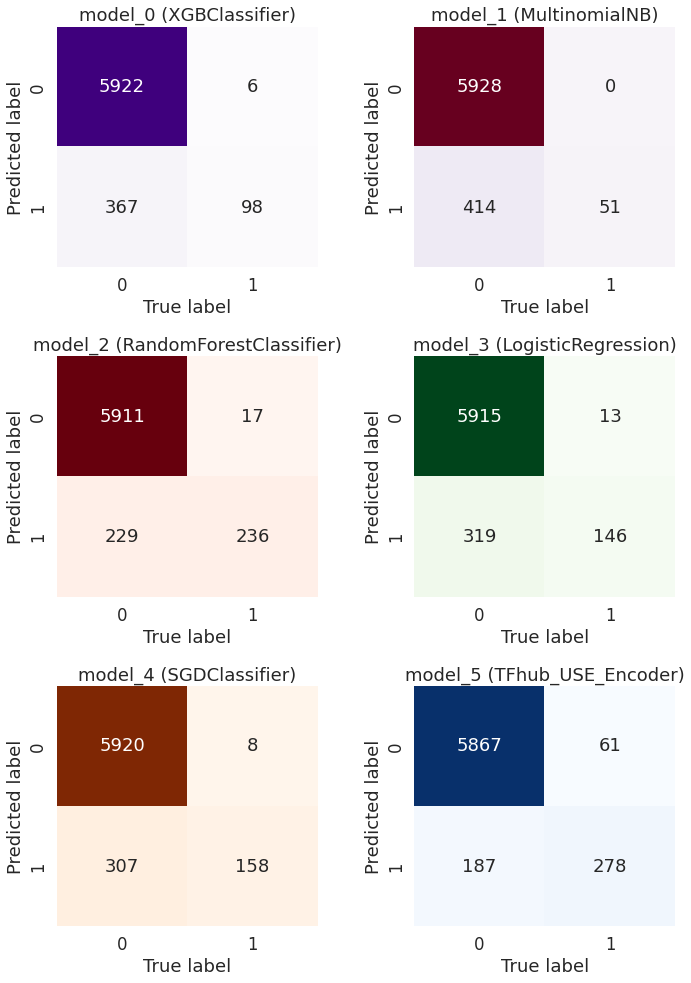

In [ ]:
sns.set(font_scale=1.5)
# Plot the confusion matrix for each model
fig, axs = plt.subplots(3, 2,figsize=(10, 14))
sns.heatmap(confusion_matrix(val_labels, y0_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[0, 0],
                  cmap= 'Purples'
                     )
axs[0, 0].set_title('model_0 (XGBClassifier)')
axs[0, 0].set_xlabel("True label")
axs[0, 0].set_ylabel("Predicted label")

sns.heatmap(confusion_matrix(val_labels, y1_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[0, 1],
                  cmap='PuRd'
                     )
axs[0, 1].set_title('model_1 (MultinomialNB)')
axs[0, 1].set_xlabel("True label")
axs[0, 1].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y2_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[1, 0],
                  cmap='Reds'
                     )
axs[1, 0].set_title('model_2 (RandomForestClassifier)')
axs[1, 0].set_xlabel("True label")
axs[1, 0].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y3_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[1, 1],
                  cmap='Greens'
                     )
axs[1, 1].set_title('model_3 (LogisticRegression)')
axs[1, 1].set_xlabel("True label")
axs[1, 1].set_ylabel("Predicted label")



sns.heatmap(confusion_matrix(val_labels, y4_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[2, 0],
                  cmap='Oranges'
                     )
axs[2, 0].set_title('model_4 (SGDClassifier)')
axs[2, 0].set_xlabel("True label")
axs[2, 0].set_ylabel("Predicted label")


sns.heatmap(confusion_matrix(val_labels, y5_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  ax=axs[2, 1],
                  cmap='Blues'
                     )
axs[2, 1].set_title('model_5 (TFhub_USE_Encoder)')
axs[2, 1].set_xlabel("True label")
axs[2, 1].set_ylabel("Predicted label")
plt.tight_layout(); 

## Another Option: Using DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_sentences, truncation=True, padding=True)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (46,), attention_mask: (46,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [ ]:
len(val_labels)

6393

In [ ]:
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model_6 = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model_6,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
score_6 = trainer.evaluate(val_dataset)
score_6

{'eval_loss': 0.13659814834594727}

In [ ]:
trainer.predict(val_dataset)

PredictionOutput(predictions=array([[ 3.5337665, -4.4153895],
       [ 3.551695 , -4.464211 ],
       [ 3.5490026, -4.427049 ],
       ...,
       [ 3.606403 , -4.5114074],
       [ 3.576659 , -4.4398513],
       [ 3.6108634, -4.5201077]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0], dtype=int32), metrics={'eval_loss': 0.1356007480621338})

In [ ]:
y6_predict_proba=trainer.predict(val_dataset)[0] 

y6_predict=np.argmax(y6_predict_proba,axis=-1)

In [ ]:
# Get model_6 results 
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred= y6_predict)
model_6_results

{'accuracy': 96.57437822618489,
 'f1': 0.9647849014040064,
 'precision': 0.9642621562919613,
 'recall': 0.9657437822618489}

In [ ]:
model_6_results_df=pd.DataFrame(data={'model_6 (DistilBertTokenizerFast)': model_6_results}).transpose()
model_6_results_df

,accuracy,f1,precision,recall
model_6 (DistilBertTokenizerFast),96.574378,0.964785,0.964262,0.965744


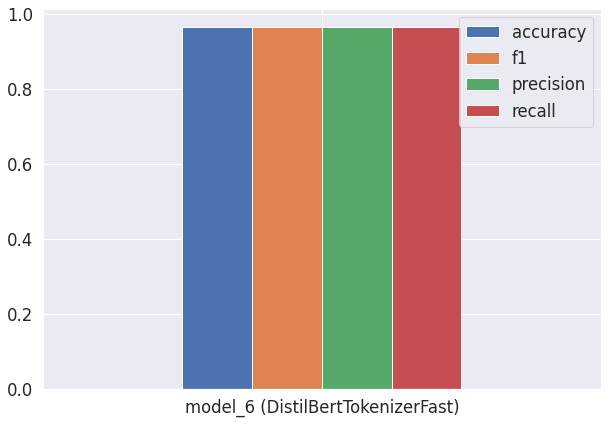

In [ ]:
# Reduce the accuracy to the same scale as other metrics 
model_6_results_df["accuracy"]= model_6_results_df["accuracy"]/100
model_6_results_df.plot(kind="bar", figsize=(10, 7))
plt.xticks(rotation='horizontal');

In [ ]:
np.unique(val_labels,return_counts=True)

(array([0, 1]), array([5928,  465]))

In [ ]:
cm_6 = confusion_matrix(val_labels, y6_predict)
cm_6

array([[5845,   83],
       [ 136,  329]])

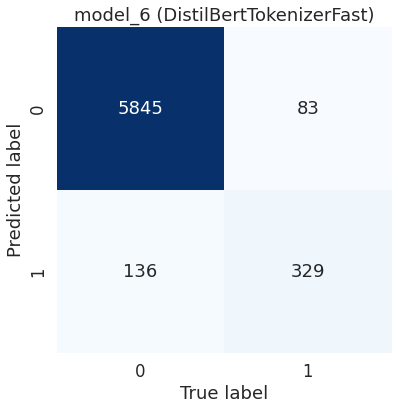

In [ ]:
# Plot the confusion matrix for model_6
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(val_labels, y6_predict),
                  annot=True,
                  cbar=False,
                  fmt='d',
                  cmap='Blues'
                     )
plt.title('model_6 (DistilBertTokenizerFast)')
plt.xlabel('True label')
plt.ylabel('Predicted label'); 

In [ ]:
pd.concat([models_results_df, model_6_results_df], axis = 0)

,accuracy,precision,recall,f1
model_0 (XGBClassifier),0.941655,0.941692,0.941655,0.924009
model_1 (MultinomialNB),0.935242,0.939469,0.935242,0.910356
model_2 (RandomForestClassifier),0.961520,0.960529,0.961520,0.956178
model_3 (LogisticRegression),0.948068,0.946604,0.948068,0.935988
model_4 (SGDClassifier),0.950727,0.950779,0.950727,0.939659
model_5 (TFhub_USE_Encoder),0.961208,0.958270,0.961208,0.958372
model_6 (DistilBertTokenizerFast),0.965744,0.964262,0.965744,0.964785


In [ ]:
# Save the best model
trainer.save_model("distilbert_model")